In [59]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf
import matplotlib.pyplot as plt

In [60]:
ANC_PATH = "./data/ANCHOR"
POS_PATH = "./data/POSITIVE"
NEG_PATH = "./data/NEGATIVE"

In [61]:
anchor = tf.data.Dataset.list_files(ANC_PATH+"/*.jpg").take(300)
positive = tf.data.Dataset.list_files(POS_PATH+"/*.jpg").take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+"/*.jpg").take(300)

In [62]:
def preprocess(file_path):
  byte_img = tf.io.read_file(file_path)
  img = tf.io.decode_jpeg(byte_img)
  img = tf.image.resize(img,(100,100))
  img = img / 255.0
  return img

In [63]:
dir_test = anchor.as_numpy_iterator()

In [64]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [65]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [66]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [67]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [68]:
def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image')

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)


    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [69]:
embedding = make_embedding()

In [70]:
# Siamese L1 Distance class
class L1Dist(Layer):

    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        if not isinstance(input_embedding, tf.Tensor):
            input_embedding = tf.convert_to_tensor(input_embedding)
        if not isinstance(validation_embedding, tf.Tensor):
            validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)

In [71]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [72]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

In [73]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)
        yhat = tf.reshape(yhat, batch[2].shape)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    print(loss)

    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [74]:
siamese_model = make_siamese_model()

In [75]:
from tensorflow.keras.metrics import Precision, Recall

In [76]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            yhat = tf.reshape(yhat, batch[2].shape)
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())

In [77]:
dt = train_data.as_numpy_iterator()

In [78]:
siamese_model(dt.next()[:2])

<tf.Tensor: shape=(1, 16, 1), dtype=float32, numpy=
array([[[0.49918777],
        [0.4989131 ],
        [0.4996076 ],
        [0.4996079 ],
        [0.50076324],
        [0.5000422 ],
        [0.5003084 ],
        [0.49940062],
        [0.50010675],
        [0.5010101 ],
        [0.4982299 ],
        [0.49974284],
        [0.4988582 ],
        [0.49904704],
        [0.4997453 ],
        [0.4997834 ]]], dtype=float32)>

In [79]:
dt.next()[2]

array([1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [106]:
EPOCHS = 10
train(train_data, EPOCHS)


 Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 700ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 764ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 745ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 820ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 814ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
1/1 ━━━━━━━━

In [107]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [108]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [109]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step


In [110]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat[0]]

[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0]

In [111]:
y_true

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [112]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [113]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [114]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 689ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 706ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1.0 0.978022


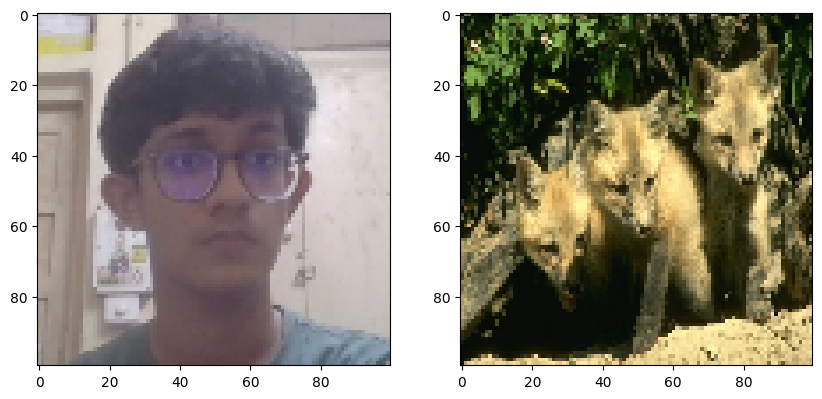

In [115]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [116]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [117]:
L1Dist

__main__.L1Dist

In [118]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [119]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


array([[[1.3649077e-07],
        [1.2613320e-07],
        [6.1032814e-01],
        [4.4993402e-07]]], dtype=float32)

In [120]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [121]:
import os, cv2
import numpy as np
os.listdir(os.path.join('application_data', 'verification_images'))

['00aaa267-54b1-11ef-967b-581cf82073d4.jpg',
 '00b00591-54b1-11ef-9fa6-581cf82073d4.jpg',
 '00b55975-54b1-11ef-aad2-581cf82073d4.jpg',
 '00c95e79-54b1-11ef-aeb2-581cf82073d4.jpg',
 '0a0168f2-54b1-11ef-ab9c-581cf82073d4.jpg',
 '0a0ae9aa-54b1-11ef-995a-581cf82073d4.jpg',
 '0a102bad-54b1-11ef-ba36-581cf82073d4.jpg',
 '0a166268-54b1-11ef-9e4d-581cf82073d4.jpg',
 '0a2db1ae-54b1-11ef-9e96-581cf82073d4.jpg',
 '0a462230-54b1-11ef-a603-581cf82073d4.jpg',
 '0a4bd902-54b1-11ef-a6db-581cf82073d4.jpg',
 '0a5fb21d-54b1-11ef-add9-581cf82073d4.jpg',
 '0a6418bd-54b1-11ef-b83f-581cf82073d4.jpg',
 '0a697772-54b1-11ef-92b5-581cf82073d4.jpg',
 '0a8c1098-54b1-11ef-9dab-581cf82073d4.jpg',
 '0a9e762c-54b1-11ef-ace9-581cf82073d4.jpg',
 '0aa3dfd0-54b1-11ef-8c32-581cf82073d4.jpg',
 '0ab802ee-54b1-11ef-af3a-581cf82073d4.jpg',
 '0acc29b3-54b1-11ef-9d82-581cf82073d4.jpg',
 '0ae2c0d0-54b1-11ef-b84b-581cf82073d4.jpg',
 '0ae97eaf-54b1-11ef-b790-581cf82073d4.jpg',
 '0af6bab2-54b1-11ef-a867-581cf82073d4.jpg',
 '0afc79d7

In [122]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [123]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\00aaa267-54b1-11ef-967b-581cf82073d4.jpg
application_data\verification_images\00b00591-54b1-11ef-9fa6-581cf82073d4.jpg
application_data\verification_images\00b55975-54b1-11ef-aad2-581cf82073d4.jpg
application_data\verification_images\00c95e79-54b1-11ef-aeb2-581cf82073d4.jpg
application_data\verification_images\0a0168f2-54b1-11ef-ab9c-581cf82073d4.jpg
application_data\verification_images\0a0ae9aa-54b1-11ef-995a-581cf82073d4.jpg
application_data\verification_images\0a102bad-54b1-11ef-ba36-581cf82073d4.jpg
application_data\verification_images\0a166268-54b1-11ef-9e4d-581cf82073d4.jpg
application_data\verification_images\0a2db1ae-54b1-11ef-9e96-581cf82073d4.jpg
application_data\verification_images\0a462230-54b1-11ef-a603-581cf82073d4.jpg
application_data\verification_images\0a4bd902-54b1-11ef-a6db-581cf82073d4.jpg
application_data\verification_images\0a5fb21d-54b1-11ef-add9-581cf82073d4.jpg
application_data\verification_images\0a6418bd-54b1-11ef-b83f-581

In [124]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [128]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [104]:
np.sum(np.squeeze(results) > 0.9)

0

In [105]:
results

[array([[[0.71750313]]], dtype=float32),
 array([[[0.76537853]]], dtype=float32),
 array([[[0.78066546]]], dtype=float32),
 array([[[0.77394956]]], dtype=float32),
 array([[[0.74378717]]], dtype=float32),
 array([[[0.76512116]]], dtype=float32),
 array([[[0.7676093]]], dtype=float32),
 array([[[0.7304947]]], dtype=float32),
 array([[[0.744022]]], dtype=float32),
 array([[[0.6788735]]], dtype=float32),
 array([[[0.6975194]]], dtype=float32),
 array([[[0.6932399]]], dtype=float32),
 array([[[0.70237494]]], dtype=float32),
 array([[[0.6944752]]], dtype=float32),
 array([[[0.65542924]]], dtype=float32),
 array([[[0.66092515]]], dtype=float32),
 array([[[0.6703986]]], dtype=float32),
 array([[[0.7053711]]], dtype=float32),
 array([[[0.7233139]]], dtype=float32),
 array([[[0.6804507]]], dtype=float32),
 array([[[0.6613518]]], dtype=float32),
 array([[[0.6768229]]], dtype=float32),
 array([[[0.66451645]]], dtype=float32),
 array([[[0.7099497]]], dtype=float32),
 array([[[0.7070871]]], dtype=f